# Regression: Variable Selection techniques
#### Hyunwoo Woo
- 2024.04.17.

# Packages and Data settings

In [1]:
import numpy as np
import pandas as pd
import pickle
import os

import statsmodels
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
os.chdir('C:/Users/hwwoo/Jupyter_Projects/methods') # Write your path where the data belongs to
print(os.getcwd()) # See your present working path

# dataframe_name = pd.read_excel("file_name.xlsx", engine = "openpyxl")
df = pd.read_excel("data_vs.xlsx", engine = "openpyxl") # Load the dataset
df.head()

C:\Users\hwwoo\Jupyter_Projects


,STEAM,INV,PROD,WIND,CDAY,OPDAY,FDAY,TEMP,STARTS,WIND_SQRD,Q2,Q3,Q4
0,10.98,5.20,0.61,7.4,31,20,22,35.3,4,54.76,0,0,0
1,11.13,5.12,0.64,8.0,29,20,25,29.7,5,64.00,0,0,0
2,12.51,6.19,0.78,7.4,31,23,17,30.8,4,54.76,0,0,0
3,8.40,3.89,0.49,7.5,30,20,22,58.8,4,56.25,1,0,0
4,9.27,6.28,0.84,5.5,31,21,0,61.4,5,30.25,1,0,0


In [3]:
# Check the dataset
print(len(df))
print(df.columns)
df.info()

25
Index(['STEAM', 'INV', 'PROD', 'WIND', 'CDAY', 'OPDAY', 'FDAY', 'TEMP',
       'STARTS', 'WIND_SQRD', 'Q2', 'Q3', 'Q4'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   STEAM      25 non-null     float64
 1   INV        25 non-null     float64
 2   PROD       25 non-null     float64
 3   WIND       25 non-null     float64
 4   CDAY       25 non-null     int64  
 5   OPDAY      25 non-null     int64  
 6   FDAY       25 non-null     int64  
 7   TEMP       25 non-null     float64
 8   STARTS     25 non-null     int64  
 9   WIND_SQRD  25 non-null     float64
 10  Q2         25 non-null     int64  
 11  Q3         25 non-null     int64  
 12  Q4         25 non-null     int64  
dtypes: float64(6), int64(7)
memory usage: 2.7 KB


# 1. Forward Selection

In [4]:
# Forward Selection function
variables = df.columns[1:].tolist() # Independent variables: I exclude the dependent variable which is located in the first (df.columns[1])
 
y = df['STEAM'] # Dependent variable (df.columns[1]): You SHOULD CHANGE this part when you use a different dataset
selected_variables = []
sl_enter = 0.05 # Criteria of p-value
 
sv_per_step = [] # selected variables in each step
adjusted_r_squared = [] # adjusted R-squared value for each step
steps = []
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) # p-value of variable

    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: # If a variable's p-value is smaller than the criteria, then select
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

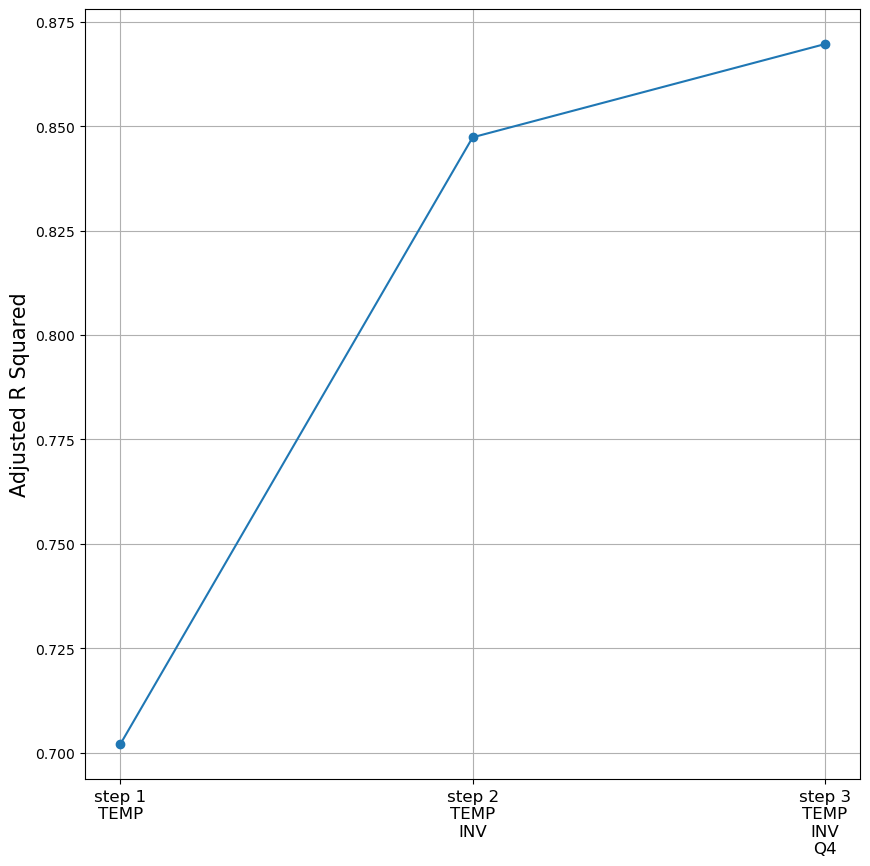

In [5]:
# Graph
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [13]:
selected_variables

['TEMP', 'INV', 'Q4']

In [18]:
# Regression Result
res = ols('STEAM ~ TEMP + INV + Q4', data=df).fit()
# Dep.var. ~ Ind.var.s
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  STEAM   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     54.37
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           4.51e-10
Time:                        19:03:24   Log-Likelihood:                -20.049
No. Observations:                  25   AIC:                             48.10
Df Residuals:                      21   BIC:                             52.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9400      0.914     10.875      0.000       8.039      11.841
TEMP          -0.0838      0.007    -11.634      0.000      -0.099      -0.069
INV            0.7430      0.147      5.042      0.000       0.437       1.049
Q4            -0.6243      0.286     -2.184      0.040      -1.219      -0.030
==============================================================================
Omnibus:                        7.790   Durbin-Watson:                   2.564
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                5.832
Skew:                           0.900   Prob(JB):                       0.0542
Kurtosis:                       4.537   Cond. No.                         436.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2. Backward Elimination

In [19]:
# Backward Elimination function
variables = df.columns[1:].tolist() # Independent variables: I exclude the dependent variable which is located in the first (df.columns[1])
 
y = df['STEAM'] # Dependent variable (df.columns[1]): You SHOULD CHANGE this part when you use a different dataset
selected_variables = variables # At first, selecting all vars.
sl_remove = 0.05 # p-value criteria
 
sv_per_step = []
adjusted_r_squared = []
steps = []
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(df[selected_variables])
    p_vals = sm.OLS(y,X).fit().pvalues[1:] # Do not consider the p-value of the intercept
    max_pval = p_vals.max() # Maximum p-value
    if max_pval >= sl_remove: # If a variable's p-value is smaller than the criteria, then select
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

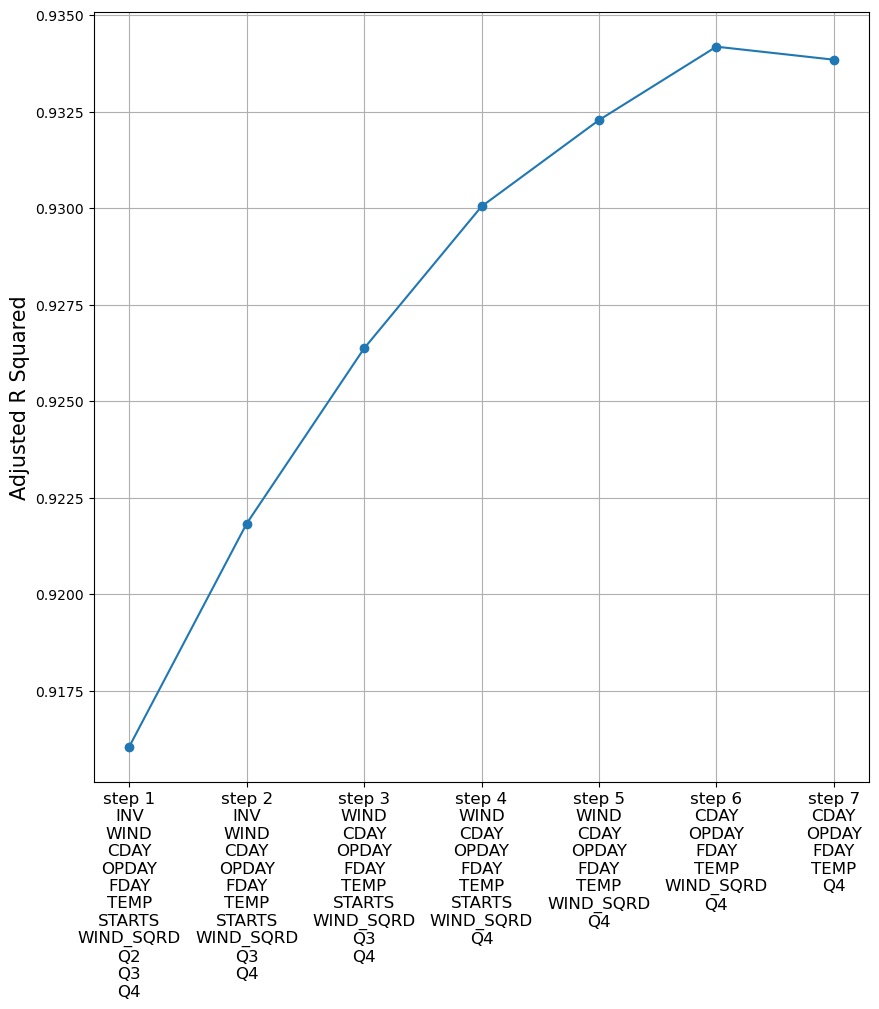

In [20]:
# Graph
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [21]:
selected_variables

['CDAY', 'OPDAY', 'FDAY', 'TEMP', 'Q4']

In [22]:
res = ols('STEAM ~ CDAY + OPDAY + FDAY + TEMP + Q4', data=df).fit() # Dep.var. ~ Ind.Vars.
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  STEAM   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     68.75
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           1.67e-11
Time:                        19:08:04   Log-Likelihood:                -10.321
No. Observations:                  25   AIC:                             32.64
Df Residuals:                      19   BIC:                             39.96
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2069      3.796     -0.054      0.957      -8.153       7.739
CDAY           0.4020      0.116      3.461      0.003       0.159       0.645
OPDAY          0.1822      0.029      6.203      0.000       0.121       0.244
FDAY          -0.0501      0.018     -2.789      0.012      -0.088      -0.012
TEMP          -0.1066      0.011     -9.646      0.000      -0.130      -0.084
Q4            -1.0009      0.219     -4.575      0.000      -1.459      -0.543
==============================================================================
Omnibus:                        0.146   Durbin-Watson:                   2.536
Prob(Omnibus):                  0.930   Jarque-Bera (JB):                0.152
Skew:                          -0.138   Prob(JB):                        0.927
Kurtosis:                       2.735   Cond. No.                     2.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3. Stepwise Selection

In [23]:
# Stepwise Selection function
variables = df.columns[1:].tolist() # Independent variables: I exclude the dependent variable which is located in the first (df.columns[1])
 
y = df['STEAM'] # Dependent variable (df.columns[1]): You SHOULD CHANGE this part when you use a different dataset
selected_variables = []
sl_enter = 0.05 # p-value criteria
sl_remove = 0.05 # p-value criteria
 
sv_per_step = []
adjusted_r_squared = []
steps = []
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) # p-value of vars.

    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: # If a variable's p-value is smaller than the criteria, then select
        selected_variables.append(pval.idxmin())

        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] # Do not consider the p-value of the intercept
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: # If a variable's p-value is smaller than the criteria, then select
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

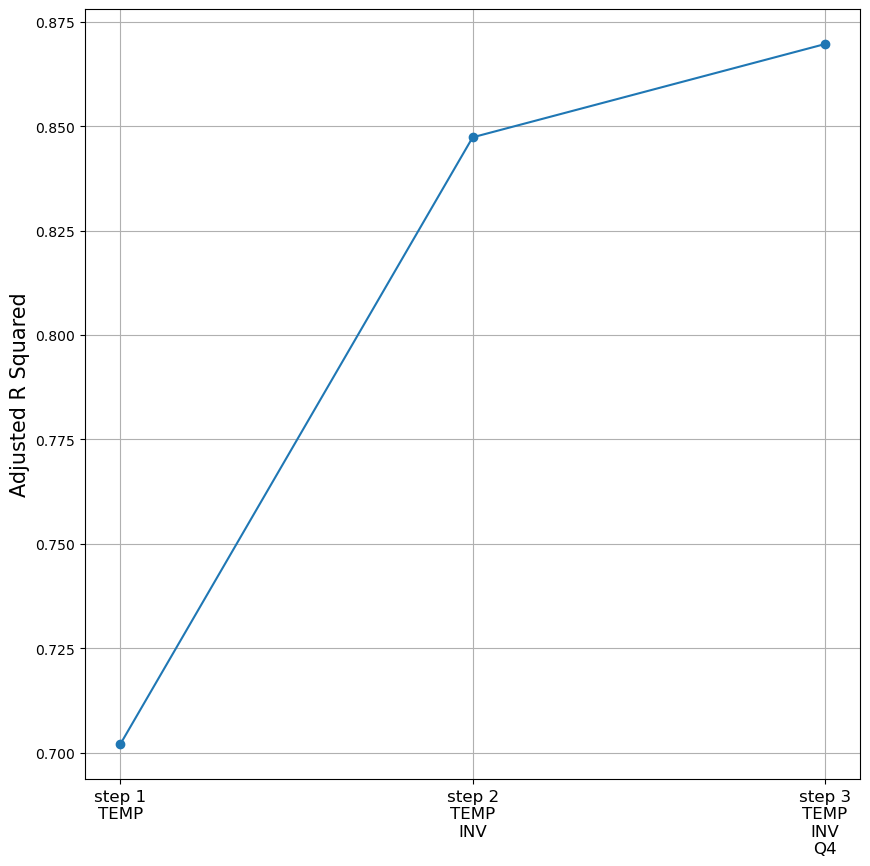

In [24]:
# Graph
fig = plt.figure(figsize=(10,10))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [25]:
selected_variables

['TEMP', 'INV', 'Q4']

In [27]:
res = ols('STEAM ~ TEMP + INV + Q4', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  STEAM   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     54.37
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           4.51e-10
Time:                        19:11:31   Log-Likelihood:                -20.049
No. Observations:                  25   AIC:                             48.10
Df Residuals:                      21   BIC:                             52.97
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9400      0.914     10.875      0.000       8.039      11.841
TEMP          -0.0838      0.007    -11.634      0.000      -0.099      -0.069
INV            0.7430      0.147      5.042      0.000       0.437       1.049
Q4            -0.6243      0.286     -2.184      0.040      -1.219      -0.030
==============================================================================
Omnibus:                        7.790   Durbin-Watson:                   2.564
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                5.832
Skew:                           0.900   Prob(JB):                       0.0542
Kurtosis:                       4.537   Cond. No.                         436.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""